In [12]:
%matplotlib inline
import random
random.seed(0)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, GridSearchCV, validation_curve

In [2]:
# Load data
data_white = pd.read_csv('data/winequality-white.csv', delimiter=';')
data_red = pd.read_csv('data/winequality-red.csv', delimiter=';')
data_white["type"] = 0
data_red["type"] = 1

In [3]:
data = data_white.append(data_red, ignore_index=True)
data = data.dropna()

In [4]:
X, y = data.drop('quality', axis=1), data.quality
y = (y<6).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

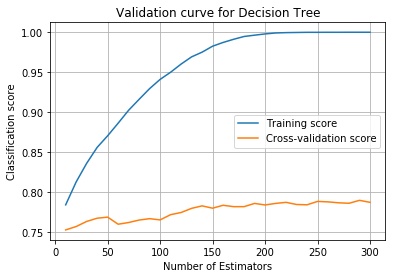

In [6]:
max_trees = 300
seed = 0
n_cv = 5

dt = DecisionTreeClassifier(max_depth=3)
ada = AdaBoostClassifier(base_estimator=dt, random_state=seed)
n_est_range = np.arange(10,max_trees+1, 10)
train_scores, test_scores = validation_curve(ada, X_train, y_train, param_name="n_estimators", param_range=n_est_range, cv=n_cv, n_jobs=-1)

plt.figure()
plt.plot(n_est_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(n_est_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for Decision Tree')
plt.xlabel('Number of Estimators')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [7]:
n_est_range = np.arange(10,max_trees+1, 10)
tuned_params = {'n_estimators' : n_est_range}
clf = GridSearchCV(ada, param_grid=tuned_params, cv=n_cv, n_jobs=-1)

clf.fit(X_train, y_train)
print("Best parameters set for decision tree found on development set:")
print(clf.best_params_)
y_pred = clf.predict(X_test)
print('Accuracy of decision tree is %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Best parameters set for decision tree found on development set:
{'n_estimators': 290}
Accuracy of decision tree is 79.38%


In [8]:
train_sizes=np.linspace(.3, 1.0, 5)

train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=n_cv, train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

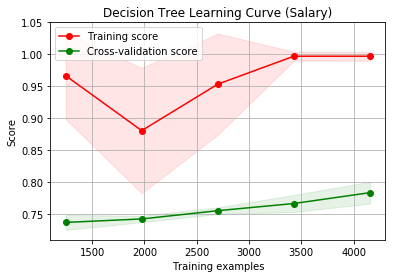

In [9]:
plt.figure()
plt.title("Decision Tree Learning Curve (Salary)")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")

plt.show()

Text(0.5,0,'False Positive Rate')

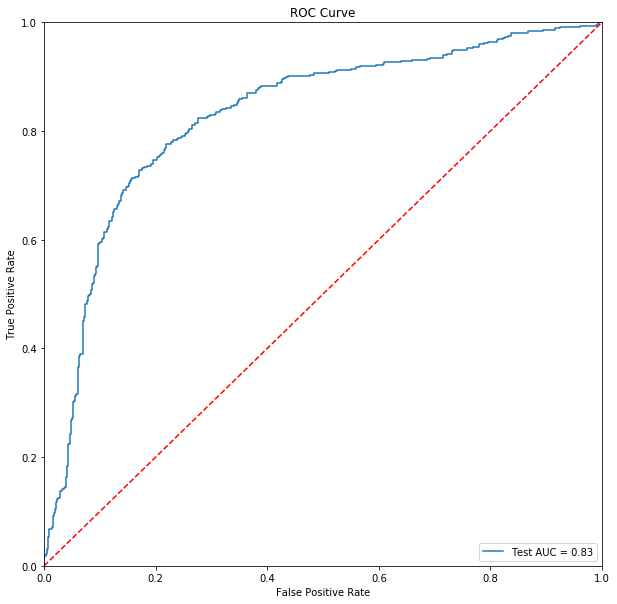

In [10]:
preds_test = clf.predict_proba(X_test)[:,1]
fpr_test, tpr_test, threshold_test = roc_curve(y_test, preds_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(10, 10))
plt.title('ROC Curve')
plt.plot(fpr_test, tpr_test, label = 'Test AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [13]:
print(roc_auc_score(y_test,preds_test))

0.8277769609644932


In [14]:
print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.85      0.83      0.84       854
          1       0.69      0.72      0.70       446

avg / total       0.80      0.79      0.79      1300

